In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import glob
import uuid
import random
import platform
import ecgdetectors
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import lognorm, norm, halfnorm

import src.data
import utils
import utils.wavelet
import utils.data
import utils.data.augmentation
import utils.visualization
import utils.visualization.plot
import utils.torch
import utils.torch.nn
import utils.torch.nn as nn
import utils.torch.loss
import utils.torch.train
import utils.torch.data
import utils.torch.preprocessing
import utils.torch.models
import utils.torch.models.lego
import utils.torch.models.variational
import utils.torch.models.classification

from utils.signal import StandardHeader

# Training the network

# Load execution configuration

In [3]:
# with open('./configurations/UNet4LevelsCrossEntropy.json', 'r') as f:
#     execution = json.load(f)

### 1. Load data
#### 1.1. Load individual segments

In [4]:
P = utils.pickleload(os.path.join('.','pickle','Psignal.pkl'))
PQ = utils.pickleload(os.path.join('.','pickle','PQsignal.pkl'))
QRS = utils.pickleload(os.path.join('.','pickle','QRSsignal.pkl'))
ST = utils.pickleload(os.path.join('.','pickle','STsignal.pkl'))
T = utils.pickleload(os.path.join('.','pickle','Tsignal.pkl'))
TP = utils.pickleload(os.path.join('.','pickle','TPsignal.pkl'))

#### 1.2. Filter out faulty segments

In [5]:
for key in (['104_II','104_III','104_AVR','104_AVF','103_III'] + 
            ['74_{}'.format(h) for h in StandardHeader] + 
            ['111_{}'.format(h) for h in StandardHeader] +
            ['95_{}'.format(h) for h in StandardHeader] + 
            ['103_{}'.format(h) for h in StandardHeader] +
            ['34_{}'.format(h) for h in StandardHeader]):
    [P.pop(k) for k in list(P.keys()) if k.startswith('{}###'.format(key))]
    [PQ.pop(k) for k in list(PQ.keys()) if k.startswith('{}###'.format(key))]
    [QRS.pop(k) for k in list(QRS.keys()) if k.startswith('{}###'.format(key))]
    [ST.pop(k) for k in list(ST.keys()) if k.startswith('{}###'.format(key))]
    [T.pop(k) for k in list(T.keys()) if k.startswith('{}###'.format(key))]
    [TP.pop(k) for k in list(TP.keys()) if k.startswith('{}###'.format(key))]

In [6]:
for key in []: 
    if key in P: P.pop(key)
for key in []: 
    if key in PQ: PQ.pop(key)
for key in ['7_V2###0','7_V2###2','7_V2###4','95_V4###0','95_V4###1','95_V4###2']: 
    if key in QRS: QRS.pop(key)
for key in []: 
    if key in ST: ST.pop(key)
for key in []: 
    if key in T: T.pop(key)
for key in (['52_III###4','34_V6###6','74_V4###0','74_V4###1','74_V4###2',
             '74_V4###3','74_V4###4','74_V4###5','74_V4###6','74_V4###7',] + 
            ['111_V2###{}'.format(i) for i in range(7)]): 
    if key in TP: TP.pop(key)

#### 1.3. Normalize amplitudes & get amplitude distributions

In [7]:
metric = np.max

amplitudes = {k.split('###')[0]: [] for k in list(QRS)}
for k in QRS:
    g = k.split('###')[0]
    segment = utils.signal.on_off_correction(QRS[k])
    amplitudes[g].append(np.max(segment) - np.min(segment))

In [8]:
Pamplitudes = []
for k in P:
    segment = utils.signal.on_off_correction(P[k])/metric(amplitudes[k.split('###')[0]])
    Pamplitudes.append(segment.max()-segment.min())
Pamplitudes = np.array(Pamplitudes)
PQamplitudes = []
for k in PQ:
    segment = utils.signal.on_off_correction(PQ[k])/metric(amplitudes[k.split('###')[0]])
    PQamplitudes.append(segment.max()-segment.min())
PQamplitudes = np.array(PQamplitudes)
QRSamplitudes = []
for k in QRS:
    segment = utils.signal.on_off_correction(QRS[k])/metric(amplitudes[k.split('###')[0]])
    QRSamplitudes.append(segment.max()-segment.min())
QRSamplitudes = np.array(QRSamplitudes)
STamplitudes = []
for k in ST:
    segment = utils.signal.on_off_correction(ST[k])/metric(amplitudes[k.split('###')[0]])
    STamplitudes.append(segment.max()-segment.min())
STamplitudes = np.array(STamplitudes)
Tamplitudes = []
for k in T:
    segment = utils.signal.on_off_correction(T[k])/metric(amplitudes[k.split('###')[0]])
    Tamplitudes.append(segment.max()-segment.min())
Tamplitudes = np.array(Tamplitudes)
TPamplitudes = []
for k in TP:
    segment = utils.signal.on_off_correction(TP[k])/metric(amplitudes[k.split('###')[0]])
    TPamplitudes.append(segment.max()-segment.min())
TPamplitudes = np.array(TPamplitudes)

In [9]:
Pamplitudes = lognorm(*lognorm.fit(Pamplitudes))
PQamplitudes = lognorm(*lognorm.fit(PQamplitudes[PQamplitudes<0.3]))
QRSamplitudes = lognorm(*lognorm.fit(QRSamplitudes))
STamplitudes = lognorm(*lognorm.fit(STamplitudes))
Tamplitudes = lognorm(*lognorm.fit(Tamplitudes[(Tamplitudes>0.05) & (Tamplitudes<0.5)]))
TPamplitudes = lognorm(*lognorm.fit(TPamplitudes[TPamplitudes<0.4]))

In [10]:
for k in list(P.keys()):
    segment = utils.signal.on_off_correction(P[k])
    P[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(P[k])) or np.any(np.isnan(P[k])):
        P.pop(k)
for k in list(PQ.keys()):
    segment = utils.signal.on_off_correction(PQ[k])
    PQ[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(PQ[k])) or np.any(np.isnan(PQ[k])):
        PQ.pop(k)
for k in list(QRS.keys()):
    segment = utils.signal.on_off_correction(QRS[k])
    QRS[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(QRS[k])) or np.any(np.isnan(QRS[k])):
        QRS.pop(k)
for k in list(ST.keys()):
    segment = utils.signal.on_off_correction(ST[k])
    ST[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(ST[k])) or np.any(np.isnan(ST[k])):
        ST.pop(k)
for k in list(T.keys()):
    segment = utils.signal.on_off_correction(T[k])
    T[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(T[k])) or np.any(np.isnan(T[k])):
        T.pop(k)
for k in list(TP.keys()):
    segment = utils.signal.on_off_correction(TP[k])
    TP[k] = segment/(np.max(segment)-np.min(segment))
    if np.any(np.isinf(TP[k])) or np.any(np.isnan(TP[k])):
        TP.pop(k)

<ipython-input-10-0e724456727d>:8: RuntimeWarning: invalid value encountered in true_divide
  PQ[k] = segment/(np.max(segment)-np.min(segment))
<ipython-input-10-0e724456727d>:18: RuntimeWarning: invalid value encountered in true_divide
  ST[k] = segment/(np.max(segment)-np.min(segment))


#### 1.4. Split into train and test

In [11]:
all_keys = {}
for k in list(P) + list(PQ) + list(QRS) + list(ST) + list(T) + list(TP):
    uid = k.split('###')[0].split('_')[0].split('-')[0]
    if uid not in all_keys:
        all_keys[uid] = [k]
    else:
        all_keys[uid].append(k)
        
# Get database and file
filenames = []
database = []
for k in all_keys:
    filenames.append(k)
    if k.startswith('SOO'):
        database.append(0)
    elif k.startswith('sel'):
        database.append(1)
    else:
        database.append(2)
filenames = np.array(filenames)
database = np.array(database)

In [12]:
with open('./configurations/UNet5Levels.json', 'r') as f:
    execution = json.load(f)

random.seed(execution['seed'])
np.random.seed(execution['seed'])
torch.random.manual_seed(execution['seed'])
splitter = sklearn.model_selection.StratifiedKFold(5).split(filenames,database)

In [13]:
for ix_train,ix_test in splitter:
    train_keys, test_keys = ([],[])
    for k in np.array(filenames)[ix_train]: train_keys += all_keys[k]
    for k in np.array(filenames)[ix_test]:  test_keys += all_keys[k]
    
    # Divide train/test segments
    Ptrain = {k: P[k] for k in P if k in train_keys}
    PQtrain = {k: PQ[k] for k in PQ if k in train_keys}
    QRStrain = {k: QRS[k] for k in QRS if k in train_keys}
    STtrain = {k: ST[k] for k in ST if k in train_keys}
    Ttrain = {k: T[k] for k in T if k in train_keys}
    TPtrain = {k: TP[k] for k in TP if k in train_keys}

    Ptest = {k: P[k] for k in P if k in test_keys}
    PQtest = {k: PQ[k] for k in PQ if k in test_keys}
    QRStest = {k: QRS[k] for k in QRS if k in test_keys}
    STtest = {k: ST[k] for k in ST if k in test_keys}
    Ttest = {k: T[k] for k in T if k in test_keys}
    TPtest = {k: TP[k] for k in TP if k in test_keys}
    
    dataset_train = src.data.Dataset(Ptrain, QRStrain, Ttrain, PQtrain, STtrain, TPtrain, 
                                     Pamplitudes, QRSamplitudes, Tamplitudes, PQamplitudes, 
                                     STamplitudes, TPamplitudes, 200*execution['loader']['batch_size'],
                                     labels_as_masks=False)
    dataset_test = src.data.Dataset(Ptest, QRStest, Ttest, PQtest, STtest, TPtest, 
                                    Pamplitudes, QRSamplitudes, Tamplitudes, PQamplitudes, 
                                    STamplitudes, TPamplitudes, 200*execution['loader']['batch_size'],
                                    labels_as_masks=False)
    
    # Create dataloaders
    loader_train = torch.utils.data.DataLoader(dataset_train,**execution['loader'])
    loader_test = torch.utils.data.DataLoader(dataset_test,**execution['loader'])
    
    # Define model
    model = nn.ModelGraph(execution['model']).float()
    
    # 
    break

In [14]:
with open('./configurations/UNet5LevelsCrossEntropy.json', 'r') as f:
    execution = json.load(f)

# Define model
model = nn.ModelGraph(execution['model']).float().cuda()


/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


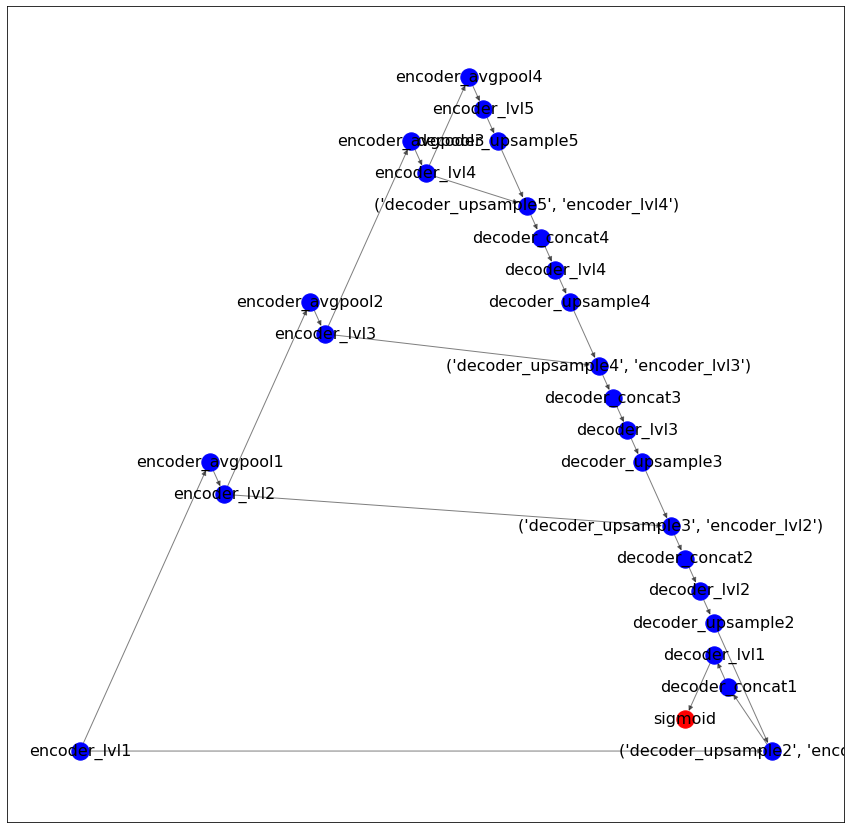

In [15]:
plt.figure(figsize=(15,15))
model.draw_networkx()

In [16]:
%%time
for x,y in loader_test:
    break

CPU times: user 381 ms, sys: 8 µs, total: 381 ms
Wall time: 380 ms


In [17]:
# Loss
criterion = lambda X,y,y_pred: utils.torch.loss.CrossEntropyLoss()(y_pred, y.long())
metric = lambda X,y,y_pred: utils.torch.loss.CrossEntropyLoss()(y_pred, y.long())
# criterion = lambda X,y,y_pred: utils.torch.loss.DiceLoss()(y_pred, y)
# metric = lambda X,y,y_pred: utils.torch.loss.DiceLoss()(y_pred, y)

state = {
    'epoch'         : 0,
    'device'        : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'optimizer'     : utils.class_selector('torch.optim',execution['optimizer']['class'])(model.parameters(), **execution['optimizer']['arguments']),
    'root_dir'      : './'
}
if 'scheduler' in execution:
    state['scheduler'] = utils.class_selector('torch.optim.lr_scheduler',execution['scheduler']['class'])(state['optimizer'], **execution['scheduler']['arguments'])

state = utils.torch.train.train_model(model,state,execution,loader_train, loader_test, criterion, metric, smaller=False)

(Valid) Epoch   1/500, Loss      0.988: 100%|██████████| 200/200 [01:20<00:00,  2.48it/s]
/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
(Train) Epoch  44/500, Loss      0.843: 100%|██████████| 200/200 [01:36<00:00,  2.06it/s]


(Valid) Epoch  89/500, Loss      0.806: 100%|██████████| 200/200 [01:19<00:00,  2.51it/s]


(Train) Epoch 135/500, Loss      0.796: 100%|██████████| 200/200 [01:40<00:00,  1.98it/s]


(Valid) Epoch 180/500, Loss      0.787: 100%|██████████| 200/200 [01:19<00:00,  2.52it/s]


(Valid) Epoch 213/500, Loss      0.793:  86%|████████▌ | 172/200 [01:09<00:11,  2.48it/s]


KeyboardInterrupt: 

In [17]:
# Save model
torch.save(model,'./modelo5nivscrossentropy.state',pickle_module=dill)

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(mo

[autoreload of pathlib failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
TypeError: __class__ assignment: 'PosixPath' object layout differs from 'PosixPath'
]
[autoreload of typing failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_ob

AttributeError: module 'linecache' has no attribute '_ipython_cache'

[autoreload of socket failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
TypeError: __class__ assignment: 'socket' object layout differs from 'socket'
]
[autoreload of ssl failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  F

In [ ]:
%%time
for x,y in loader_test:
    break

In [ ]:
agkljjsgkldjs

In [ ]:
(out,) = model(x.cuda())
y2 = torch.clone(y)
y = torch.zeros((64,3,2048),dtype=bool)
y[:,0,:] = (y2 == 1)
y[:,1,:] = (y2 == 2)
y[:,2,:] = (y2 == 3)

In [ ]:
i = 2
w = 3
plt.figure(figsize=(15,5))
plt.plot(x[i,0,:])
plt.twinx()
plt.plot(y[i,w-1,:],alpha=0.5)
plt.plot(out[i,w,:].cpu().detach().numpy(),alpha=0.5)


In [20]:
list(set([k.split('###')[0] for k in test_keys]))

['sel117_0',
 '20_V6',
 '16_V2',
 '40_V4',
 '20_III',
 '39_I',
 '6_II',
 '21_I',
 '23_AVR',
 '12_AVL',
 '15_AVL',
 '30_II',
 'sel14157_1',
 '12_V4',
 '41_V1',
 'SOO65-1-1',
 'SOO7-1-1',
 '13_I',
 '12_AVR',
 '16_V1',
 '9_II',
 '15_AVF',
 '23_V6',
 '17_I',
 '26_III',
 '37_II',
 '16_AVL',
 '9_V3',
 'SOO12-1-1',
 '24_AVR',
 '24_V3',
 'SOO21-1-1',
 '18_III',
 '41_AVF',
 '7_V1',
 'sel16795_0',
 'SOO18-1-2',
 '2_II',
 '32_AVL',
 '42_V4',
 '28_V1',
 '39_V6',
 '10_I',
 '23_V1',
 '5_V1',
 '36_V5',
 '43_V3',
 '31_V2',
 'SOO15-1-1',
 '11_AVL',
 '15_V3',
 '2_V6',
 '19_V3',
 '15_V4',
 '32_AVR',
 '7_I',
 '39_III',
 '13_AVR',
 'SOO1-1-1',
 '11_V1',
 '21_AVL',
 '26_V1',
 '36_V3',
 '37_AVF',
 '3_I',
 '42_I',
 'sel16773_1',
 'SOO23-1-1',
 '26_I',
 '29_II',
 '33_V4',
 '15_V2',
 'SOO3-1-1',
 '14_V4',
 '9_V5',
 '11_V3',
 '21_V5',
 'SOO46-1-1',
 '17_V1',
 'sel17152_1',
 '24_V4',
 '22_V5',
 '2_V4',
 '30_V2',
 '33_V6',
 '36_AVL',
 '37_AVL',
 '22_AVR',
 '39_V3',
 '11_V2',
 '11_AVF',
 '24_V6',
 '29_AVL',
 '32_V1

# Test against SoO db

In [3]:
with open('./configurations/UNet5Levels.json', 'r') as f:
    execution = json.load(f)

# Define model
# model = nn.ModelGraph(execution['model']).float().cuda()
model = torch.load('./modelo5nivsdice.state').eval().float()

In [4]:
#### LOAD DATASET ####
basedir = '/media/guille/DADES/DADES/Delineator/'
Files = os.listdir(os.path.join(basedir,'SoO','RETAG'))
Files = [os.path.splitext(f)[0] for f in Files if os.path.splitext(f)[1] == '.txt']
Segmentations = pd.read_csv(os.path.join(basedir,'SoO','SEGMENTATIONS.csv'),index_col=0,header=None).T
Keys = Segmentations.keys().tolist()
Keys = [k for k in Keys if '-'.join(k.split('-')[:2]) in Files]
database = pd.read_csv(os.path.join(basedir,'SoO','DATABASE_MANUAL.csv'))

# Data storage
QRSsignalSoO = dict()
QRSgroupSoO = dict()

for k in tqdm.tqdm(Keys):
    # Retrieve general information
    fname = '-'.join(k.split('-')[:2]) + '.txt'
    ID = int(k.split('-')[0])
    
    # Read signal and segmentation
    Signal = pd.read_csv(os.path.join(basedir,'SoO','RETAG',fname),index_col=0).values
    (son,soff) = Segmentations[k]
    fs = database['Sampling_Freq'][database['ID'] == int(ID)].values[0]
    
    # Check correct segmentation
    if son > soff:
        print("(!!!) Check file   {:>10s} has onset ({:d}) > offset ({:d})".format(k, son, soff))
        continue

    # Up/downsample to 1000 Hz
    factor = int(fs/250)
    Signal = np.round(sp.signal.decimate(Signal.T, factor)).T
    fs = fs/factor

    # Filter baseline wander and high freq. noise
    Signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/fs, 'high'),Signal.T).T
    Signal = sp.signal.filtfilt(*sp.signal.butter(4, 125.0/fs,  'low'),Signal.T).T
    
    for i in range(len(StandardHeader)):
        # Store data
        QRSsignalSoO[k+'###'+str(StandardHeader[i])] = Signal[:,i]

100%|██████████| 288/288 [00:16<00:00, 17.62it/s]


In [21]:
list(set([k.split('###')[0] for k in test_keys]))

['sel117_0',
 '20_V6',
 '16_V2',
 '40_V4',
 '20_III',
 '39_I',
 '6_II',
 '21_I',
 '23_AVR',
 '12_AVL',
 '15_AVL',
 '30_II',
 'sel14157_1',
 '12_V4',
 '41_V1',
 'SOO65-1-1',
 'SOO7-1-1',
 '13_I',
 '12_AVR',
 '16_V1',
 '9_II',
 '15_AVF',
 '23_V6',
 '17_I',
 '26_III',
 '37_II',
 '16_AVL',
 '9_V3',
 'SOO12-1-1',
 '24_AVR',
 '24_V3',
 'SOO21-1-1',
 '18_III',
 '41_AVF',
 '7_V1',
 'sel16795_0',
 'SOO18-1-2',
 '2_II',
 '32_AVL',
 '42_V4',
 '28_V1',
 '39_V6',
 '10_I',
 '23_V1',
 '5_V1',
 '36_V5',
 '43_V3',
 '31_V2',
 'SOO15-1-1',
 '11_AVL',
 '15_V3',
 '2_V6',
 '19_V3',
 '15_V4',
 '32_AVR',
 '7_I',
 '39_III',
 '13_AVR',
 'SOO1-1-1',
 '11_V1',
 '21_AVL',
 '26_V1',
 '36_V3',
 '37_AVF',
 '3_I',
 '42_I',
 'sel16773_1',
 'SOO23-1-1',
 '26_I',
 '29_II',
 '33_V4',
 '15_V2',
 'SOO3-1-1',
 '14_V4',
 '9_V5',
 '11_V3',
 '21_V5',
 'SOO46-1-1',
 '17_V1',
 'sel17152_1',
 '24_V4',
 '22_V5',
 '2_V4',
 '30_V2',
 '33_V6',
 '36_AVL',
 '37_AVL',
 '22_AVR',
 '39_V3',
 '11_V2',
 '11_AVF',
 '24_V6',
 '29_AVL',
 '32_V1

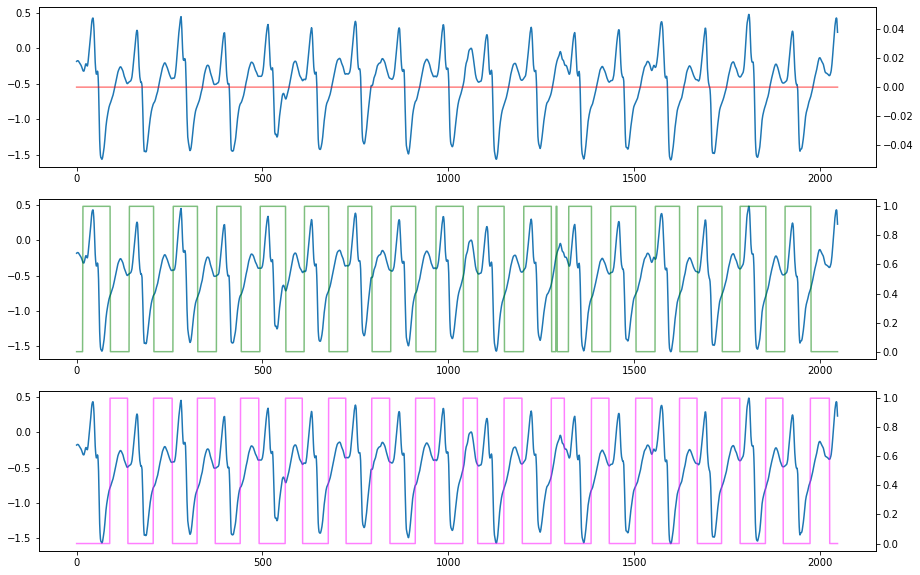

In [167]:
tmp = QRSsignalSoO['31-1-1###V6']
tmp = scipy.interpolate.interp1d(np.linspace(0,1,tmp.size),tmp)(np.linspace(0,1,1.5*tmp.size))
aaa = (skimage.util.view_as_windows(tmp/500,2048,1024)-0.5)[:,None,:]
bbb = torch.zeros((aaa.shape[0],3,2048),dtype=float)
for i in range(0,aaa.shape[0],64):
    bbb[i:i+64] = model(torch.tensor(aaa[i:i+64]).cuda().float())[0]
bbb = bbb.cpu().detach().numpy()

i = 1
w = 0
f,ax = plt.subplots(nrows=3,figsize=(15,10))
ax[0].plot(aaa[i,0,:])
ax1 = ax[0].twinx()
ax1.plot(bbb[i,0,:]>0.5,alpha=0.5,color='red')
ax[1].plot(aaa[i,0,:])
ax2 = ax[1].twinx()
ax2.plot(bbb[i,1,:]>0.5,alpha=0.5,color='green')
ax[2].plot(aaa[i,0,:])
ax3 = ax[2].twinx()
ax3.plot(bbb[i,2,:]>0.5,alpha=0.5,color='magenta')


In [ ]:
tmp2 = tmp.operations[1]

In [ ]:
tmp2.operations[2]

In [ ]:
tmp = model[0]

In [ ]:
tmp.operations[2].training

In [ ]:
tmp.operations[1]

In [ ]:
(tmp.operations[1](tmp.operations[0](torch.tensor(aaa[i:i+64]).cuda().float())))

In [ ]:
model[0](torch.tensor(aaa[i:i+64]).cuda().float())

### 2. Load model definition

In [ ]:
### IMPORT EXECUTION CONFIGURATION PARAMETERS (JSON) ###
with open("./parameters.json", 'r') as f:
    execution = json.load(f)

execution["root_directory"] = input_directory
execution["save_directory"] = output_directory

### SET RANDOM SEED ###
torch.manual_seed(execution['seed'])
random.seed(execution['seed'])
np.random.seed(execution['seed'])

### LOAD DATASET ###
# 0) Get classes
# print(list(glob.glob(os.path.join(input_directory,"*.mat"))))
classes = get_classes(input_directory,[os.path.split(f)[-1] for f in glob.glob(os.path.join(input_directory,"*.mat"))])

# 1) Load labels and compute detections
print("########## COMPUTING DETECTIONS ##########")
files = []
labels = []
detections = []
for f in tqdm.tqdm(glob.glob(os.path.join(input_directory,"*.mat"))):
    # Load data
    (signal,header) = wfdb.rdsamp(os.path.join(input_directory,os.path.splitext(f)[0]))
    signal = signal.astype('float32')

    # Use provided function for retrieving the true label
    fname, label_header, label = get_true_labels(f.replace('.mat','.hea'),classes)

    # Detect signal
    detector = ecgdetectors.Detectors(header['fs'])
    index_I = np.where(np.array(list(map(str.upper,header['sig_name']))) == 'I')[0][0]
    qrs = detector.pan_tompkins_detector(signal[:,index_I])

    # Store file name and label
    files.append(fname)
    detections.append(qrs)
    labels.append(label)

labels = np.array(labels)
files = np.array(files)

# 2) Train-test split
labels_train,labels_valid,files_train,files_valid,detections_train,detections_valid = sklearn.model_selection.train_test_split(
    labels,
    files,
    detections,
    stratify=labels.argmax(-1),
    random_state=execution['seed'],
)

# Save into folder
src.utils.pickledump(labels_train, './training/labels_train.pkl')
src.utils.pickledump(labels_valid, './training/labels_valid.pkl')
src.utils.pickledump(files_train, './training/files_train.pkl')
src.utils.pickledump(files_valid, './training/files_valid.pkl')
src.utils.pickledump(detections_train, './training/detections_train.pkl')
src.utils.pickledump(detections_valid, './training/detections_valid.pkl')

print("########## GENERATING TRAIN SET ##########")
# Generate train/test sets
X_train = []
y_train = []
X_valid = []
y_valid = []

for i in tqdm.tqdm(range(len(files_train))):
    # Retrieve the file information
    (signal,_) = wfdb.rdsamp(os.path.join(execution['root_directory'],files_train[i]))
    signal = signal.astype('float32').T

    if not execution['whole_record']:
        for j in range(1,len(detections_train[i])-1):
            onset = detections_train[i][j-1]
            offset = detections_train[i][j+1]
            interp = signal[:,onset:offset]
            interp = sp.interpolate.interp1d(np.linspace(0,1,interp.shape[1]),interp,axis=-1)(np.linspace(0,1,736)).astype('float32')
            X_train.append(interp)
            y_train.append(labels_train[i,:])
    else:
        X_train.append(signal)
        y_train.append(labels_train[i,:])

print("########## GENERATING TRAIN SET ##########")
for i in tqdm.tqdm(range(len(files_valid))):
    # Retrieve the file information
    (signal,_) = wfdb.rdsamp(os.path.join(execution['root_directory'],files_valid[i]))
    signal = signal.astype('float32').T

    if not execution['whole_record']:
        for j in range(1,len(detections_valid[i])-1):
            onset = detections_valid[i][j-1]
            offset = detections_valid[i][j+1]
            interp = signal[:,onset:offset]
            interp = sp.interpolate.interp1d(np.linspace(0,1,interp.shape[1]),interp,axis=-1)(np.linspace(0,1,736)).astype('float32')
            X_valid.append(interp)
            y_valid.append(labels_valid[i,:])
    else:
        X_valid.append(signal)
        y_valid.append(labels_valid[i,:])

y_valid = np.array(y_valid, dtype='float32')
y_train = np.array(y_train, dtype='float32')
try:
    X_train = np.array(X_train, dtype='float32')
    X_valid = np.array(X_valid, dtype='float32')
except:
    pass

### TRAIN MODEL ###
model = src.model.GAPModel(
    torch.nn.Sequential(
        src.model.CNN([12,16,16], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([16,16], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([16,32], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([32,32], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([32,64], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([64,128], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([128,256], regularization=execution['regularization_CNN'], regularize_extrema=False),
    ),
    src.model.DNN([256,128,64,32,9], regularization=execution['regularization_DNN'], regularize_extrema=False),
)

if execution['whole_record']:
    dataset_train = src.data.PaddedDataset(X_train, y_train, padding_length=execution['padding_length'],swapaxes=False, mode='edge')
    dataset_valid = src.data.PaddedDataset(X_valid, y_valid, padding_length=execution['padding_length'],swapaxes=False, mode='edge')
else:
    dataset_train = src.data.Dataset(X_train, y_train)
    dataset_valid = src.data.Dataset(X_valid, y_valid)

sampler_train = src.data.StratifiedSampler(y_train, *execution['sampler'])
sampler_valid = src.data.StratifiedSampler(y_valid, *execution['sampler'])

loader_train  = torch.utils.data.DataLoader(dataset_train, sampler=sampler_train, batch_size=execution['batch_size'], **execution['loader'])
loader_valid  = torch.utils.data.DataLoader(dataset_valid, sampler=sampler_valid, batch_size=execution['batch_size'], **execution['loader'])

# Loss
criterion = lambda X,y,y_pred: torch.nn.MultiLabelSoftMarginLoss(reduction='mean')(y_pred, y.long())
metric = lambda X,y,y_pred: src.evaluate.compute_beta_score(y.long().cpu().detach().numpy(),(torch.nn.functional.softmax(y_pred,-1) > 0.5).cpu().detach().numpy())[-1]

state = {
    'epoch'         : 0,
    'device'        : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'optimizer'     : src.utils.class_selector('torch.optim',execution['optimizer']['name'])(model.parameters(), **execution['optimizer']['arguments']),
    'root_dir'      : './'
}
if 'scheduler' in execution:
    state['scheduler'] = src.utils.class_selector('torch.optim.lr_scheduler',execution['scheduler']['name'])(state['optimizer'], **execution['scheduler']['arguments'])

print("########## TRAINING THE MODEL ##########")
state = src.train.train_model(model,state,execution,loader_train, loader_valid, criterion, metric, smaller=False)


# Boundary Loss

In [ ]:
P = skimage.segmentation.find_boundaries(y[:,0,None,:])

In [ ]:
def generate_binary_structure(rank, connectivity):
    if connectivity < 1:
        connectivity = 1
    if rank < 1:
        if connectivity < 1:
            return np.array(0, dtype=bool)
        else:
            return np.array(1, dtype=bool)
    output = np.fabs(np.indices([3] * rank) - 1)
    output = np.add.reduce(output, 0)
    
    return np.asarray(output <= connectivity, dtype=bool)

In [ ]:
struct = generate_binary_structure(ndim-1, 1)
struct[0,:]=False
struct[-1,:]=False
struct = struct[None,None,...]
struct

In [ ]:
selem = torch.tensor(selem).type(torch.uint8)

In [ ]:
import torch.nn.functional as F
bnd = F.conv2d(label_img, selem, padding=(selem.shape[2] // 2, selem.shape[2] // 2))

In [ ]:
def erosion1d(signal, selem):
    inverted = torch.logical_not(signal).type(signal.dtype)
    out = F.conv1d(inverted, selem, padding=(selem.shape[-1] // 2,)) > 0
    return torch.logical_not(out)

def dilation1d(signal, selem):
    return F.conv1d(signal, selem, padding=(selem.shape[-1] // 2,)) > 0

def erosion2d(image, selem):
    inverted = torch.logical_not(image).type(image.dtype)
    out = F.conv2d(inverted, selem, padding=(selem.shape[2] // 2, selem.shape[2] // 2)) > 0
    return torch.logical_not(out)

def dilation2d(image, selem):
    return F.conv2d(image, selem, padding=(selem.shape[2] // 2, selem.shape[2] // 2)) > 0

In [ ]:
selem = np.zeros((3,)*(ndim-1),dtype=bool)
selem[1,1,:] = True
selem1 = np.zeros((3,)*(ndim-1),dtype=bool)
selem1[0,0,:] = True
selem1[1,1,:] = True
selem1[2,2,:] = True

In [ ]:
selem1

In [ ]:
label_img.shape

In [ ]:
Pbound = skimage.morphology.dilation(label_img[:,0,...].numpy(),selem.astype('bool')).squeeze()
QRSbound = skimage.morphology.dilation(label_img[:,1,...].numpy(),selem.astype('bool')).squeeze()
Tbound = skimage.morphology.dilation(label_img[:,2,...].numpy(),selem.astype('bool')).squeeze()
out2 = np.concatenate((Pbound[:,None,:],QRSbound[:,None,:],Tbound[:,None,:]),axis=1)
Per = skimage.morphology.erosion(label_img[:,0,...].numpy(),selem.astype('bool')).squeeze()
QRSer = skimage.morphology.erosion(label_img[:,1,...].numpy(),selem.astype('bool')).squeeze()
Ter = skimage.morphology.erosion(label_img[:,2,...].numpy(),selem.astype('bool')).squeeze()
er2 = np.concatenate((Per[:,None,:],QRSer[:,None,:],Ter[:,None,:]),axis=1)

In [ ]:
out2.sum()

In [ ]:
er2.sum()

In [ ]:
out = dilation1d(label_img.type(torch.float32).squeeze(),torch.tensor(selem1).type(torch.float32))

In [ ]:
er = erosion1d(label_img.type(torch.float32).squeeze(),torch.tensor(selem1).type(torch.float32))

In [ ]:
out.sum()

In [ ]:
er.sum()

In [ ]:
i = 3
l = 1
plt.plot(er[i,l,:])
plt.plot(er2[i,l,:])

In [ ]:
np.allclose(out2.astype('bool'),out.numpy())

In [ ]:
out

In [ ]:
scipy.ndimage.morphology.binary_dilation(label_img,selem)

In [ ]:
label_img = y[:,:,None,None,:]

In [ ]:
bnds = skimage.segmentation.find_boundaries(label_img).squeeze()

In [ ]:
bnds.shape

In [ ]:
import cv2

In [ ]:
cv2.dilate(label_img.numpy(),selem)

In [ ]:
plt.plot(y[0,1,:])
plt.plot(boundaries.squeeze()[0,1,:])

In [ ]:
label_img = y[:,:,None,:]
connectivity=1
mode='thick'
background=0

In [ ]:
if label_img.dtype == torch.bool:
    label_img = label_img.type(torch.uint8)
ndim = label_img.ndim
# selem = torch.tensor(generate_binary_structure(ndim, connectivity))
selem = np.zeros((3,)*(ndim-1),dtype=bool)
selem[1,1,1,:] = True
if mode != 'subpixel':
    boundaries = skimage.morphology.dilation(label_img, selem) != skimage.morphology.erosion(label_img, selem)
    if mode == 'inner':
        foreground_image = (label_img != background)
        boundaries &= foreground_image
    elif mode == 'outer':
        max_label = torch.iinfo(label_img.dtype).max
        background_image = (label_img == background)
        selem = generate_binary_structure(ndim, ndim)
        inverted_background = torch.tensor(label_img, copy=True)
        inverted_background[background_image] = max_label
        adjacent_objects = ((skimage.morphology.dilation(label_img, selem) !=
                             skimage.morphology.erosion(inverted_background, selem)) &
                            ~background_image)
        boundaries &= (background_image | adjacent_objects)
else:
    boundaries = _find_boundaries_subpixel(label_img)


In [ ]:
boundaries

In [ ]:
skimage.morphology.dilation

In [ ]:
math.fabs()